In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="engineeringmodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
enggFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [7]:
enggFOSID = enggFOSID.filter(enggFOSID["Domain"]=="Engineering").collect()

In [8]:
len(enggFOSID)

172

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(enggFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+---------+-----------+
|   FOS_ID|     Domain|
+---------+-----------+
|107053488|Engineering|
|115903868|Engineering|
+---------+-----------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered.count()

6145845

In [16]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [17]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [31]:
(sample1,sample2) = papers_filtered1.randomSplit([0.12,0.5])

In [32]:
sample1.count()

1188974

In [33]:
from sklearn import model_selection
from sklearn.model_selection import KFold

In [34]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             1|
|             0|
|            12|
|             1|
+--------------+
only showing top 4 rows



In [35]:
sample1_pd = sample1.toPandas()

In [36]:
import numpy as np

In [37]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [38]:
from sklearn import metrics

In [39]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 1.0340974655459245)
('Mean Squared Error of EstimatedCount:', 557.641246150042)
('Root Mean Squared of with EstimatedCount:', 23.61442877035229)


In [40]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [41]:
sample1_pd.shape

(1188974, 12)

In [42]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [43]:
from sklearn.model_selection import KFold

In [44]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 1.732707168899524)
('Mean Squared Error:', 966.36962543954)
('Root Mean Squared Error:', 31.08648621892703)
('Mean Absolute Error:', 1.522740918905798)
('Mean Squared Error:', 120.36233652651208)
('Root Mean Squared Error:', 10.970977008749589)
('Mean Absolute Error:', 1.288082946702169)
('Mean Squared Error:', 88.61076895781152)
('Root Mean Squared Error:', 9.413329323773365)
('Mean Absolute Error:', 1.4292016326156538)
('Mean Squared Error:', 53.345503396686)
('Root Mean Squared Error:', 7.3038006131524424)
('Mean Absolute Error:', 0.9591277529044626)
('Mean Squared Error:', 59.96631486027655)
('Root Mean Squared Error:', 7.74379202072709)


In [47]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 13.303677037065905)


In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
featureslist=sample1_pd.columns

In [50]:
importances = regressor.feature_importances_

In [51]:
import pandas as pd

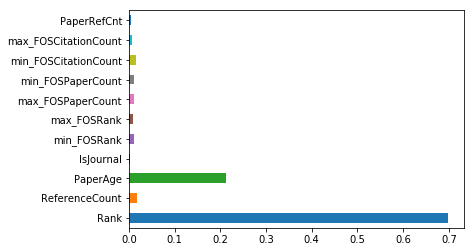

In [52]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

## XGBoost Regression model

In [53]:
import xgboost as xgb

In [54]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [55]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 237795,  237796,  237797, ..., 1188971, 1188972, 1188973]), 'TEST:', array([     0,      1,      2, ..., 237792, 237793, 237794]))
('Mean Absolute Error of XGBoost Kfold:', 1.82200442076158)
('Mean Squared Error of XGBoost Kfold:', 1041.741747171236)
('Root Mean Squared Error of XGBoost Kfold:', 32.27602433961215)
('TRAIN:', array([      0,       1,       2, ..., 1188971, 1188972, 1188973]), 'TEST:', array([237795, 237796, 237797, ..., 475587, 475588, 475589]))
('Mean Absolute Error of XGBoost Kfold:', 1.6164380863281649)
('Mean Squared Error of XGBoost Kfold:', 150.0459138268168)
('Root Mean Squared Error of XGBoost Kfold:', 12.249322994631857)
('TRAIN:', array([      0,       1,       2, ..., 1188971, 1188972, 1188973]), 'TEST:', array([475590, 475591, 475592, ..., 713382, 713383, 713384]))
('Mean Absolute Error of XGBoost Kfold:', 1.3372192835802286)
('Mean Squared Error of XGBoost Kfold:', 96.20233964437872)
('Root Mean Squared Error of XGBoost Kfold:', 9.8082791

In [56]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 14.127062159085785)


In [57]:
importances = regressor.feature_importances_

In [58]:
import pandas as pd

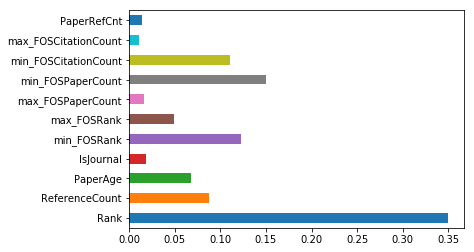

In [59]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [60]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.34933
Feature: 1, Score: 0.08741
Feature: 2, Score: 0.06821
Feature: 3, Score: 0.01898
Feature: 4, Score: 0.12316
Feature: 5, Score: 0.04898
Feature: 6, Score: 0.01697
Feature: 7, Score: 0.14978
Feature: 8, Score: 0.11107
Feature: 9, Score: 0.01142
Feature: 10, Score: 0.01469
